# Image analysis pipeline
This notebook creates a figure showing the image analysis pipeline for measuring mechanical strain in C elegans TRNs.

### Import packages

In [2]:
import time
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy import stats
from scipy.optimize import curve_fit
from statsmodels.stats import multicomp 
import pims
from nd2reader import ND2Reader 
import math
import warnings
import glob
import numpy as np
import typing
import pathlib
import seaborn as sns
import line_profiler
import trackpy as tp
import yaml
def construct_python_tuple(self, node):
    return tuple(self.construct_sequence(node))
yaml.add_constructor(u'tag:yaml.org,2002:python/tuple',
                     construct_python_tuple, Loader=yaml.SafeLoader)

start = time.time()


### Experimental parameters

In [3]:
pixel_to_micron = 0.275
analyzed_data_dir = pathlib.Path('/Users/adam/Documents/SenseOfTouchResearch/SSN_AnalyzedData/')
raw_data_dir = pathlib.Path('/Users/adam/Documents/SenseOfTouchResearch/SSN_data/')
fig_save_dir = analyzed_data_dir.joinpath('PreliminaryPlots/')

### Settings for plot aesthetics

In [4]:
sns.set(font_scale=1.2)
sns.set_style('ticks')
sns.set_palette('colorblind')

## Load data
### Start with metadata

In [5]:
analyzed_trials = analyzed_data_dir.glob('*') #glob.iglob(analyzed_data_dir + '*')
all_metadata = []
for trial in analyzed_trials:
    trial_path = trial.joinpath('metadata.yaml')
    try:
        with open(trial_path) as metadata_file:
            all_metadata.append(yaml.safe_load(metadata_file))
    except FileNotFoundError:
        pass
    except NotADirectoryError:
        pass

metadata_df = pd.DataFrame(all_metadata)

In [6]:
example_trial = 'SSN_161_001'
timestamp = metadata_df.loc[metadata_df['Experiment_id'] == example_trial]['timestamp'].values[0]
exp_dir = ''.join(str(timestamp)[:10].split('-'))
filename = pathlib.Path(raw_data_dir, exp_dir, example_trial + '.nd2')
bf_filename = filename.parent.joinpath(filename.stem + '_bf.nd2')
warnings.filterwarnings("ignore", message="Reported average frame interval")

In [7]:
params = analyzed_data_dir.joinpath(example_trial, 'trackpyBatchParams.yaml')
with open(params) as param_file:
    params=yaml.safe_load(param_file)
print(params)

{'characterize': True, 'diameter': (21, 15, 15), 'minmass': 1470, 'noise_size': 3, 'percentile': 50, 'source': None, 'timestamp': '2019-05-24-170459', 'trackpy_version': '0.4.1+35.g10f756b', 'bottom_slice': 0, 'last_timepoint': 8, 'notes': 'Increased link radius', 'roi': [214, 0, 277, 1052], 'top_slice': 54, 'tracking_seach_radius': 60}


In [8]:
bf_image = pims.open(str(bf_filename))
bf_array = np.asarray(bf_image)
bf_array = bf_array.squeeze()
bf_array = np.rot90(bf_array,1,(0,1))

images = pims.open(str(filename))
images.bundle_axes = ['z', 'y', 'x']
imageArray = np.asarray(images)
imageArray = imageArray.squeeze()

In [9]:
maxProjection = np.amax(imageArray[0] , 0) # collapse z axis
maxProjection = maxProjection.squeeze()
maxProjection = np.asarray(maxProjection)

## Process images 
### Bandpass filter


In [10]:
bp_image = tp.preprocessing.bandpass(imageArray[0],
                                     lshort=params['noise_size'],
                                     llong=params['diameter'], threshold=None, truncate=4)
max_proj_bp = np.amax(bp_image, 0)
max_proj_bp = max_proj_bp.squeeze()
max_proj_bp = np.asarray(max_proj_bp)

### Peak finder results

In [11]:
unlinked_mitos_file = analyzed_data_dir.joinpath(example_trial, 'unlinkedTrackpyBatchResults.yaml')
 
with open(unlinked_mitos_file, 'r') as yamlfile:
    unlinked_mitos_dict = yaml.safe_load(yamlfile)

parsed_dict = [{col: unlinked_mitos_dict[particle][col]
               for col in ('frame', 'x', 'y', 'z')}
               for particle in unlinked_mitos_dict.keys()]

unlinked_mitos_df = pd.DataFrame(parsed_dict)
unlinked_mitos_df['Experiment_id'] = example_trial
unlinked_mitos_df.dropna(inplace=True)

### Linked trajectories results

In [12]:
linked_mitos_file = analyzed_data_dir.joinpath(example_trial, 'mito_locations.yaml')
 
with open(linked_mitos_file, 'r') as yamlfile:
    linked_mitos_dict = yaml.safe_load(yamlfile)

parsed_dict = {k: linked_mitos_dict[k] for k in (
        'frame', 'particle', 'pressure', 'x', 'y', 'z')}
linked_mitos_df = pd.DataFrame(parsed_dict)
linked_mitos_df['Experiment_id'] = example_trial

## Plot the steps

### Set image bounds
Also need to correct some values before plotting

In [13]:
extra_image_around_roi = 10
bottom = params['roi'][2] + extra_image_around_roi
top = params['roi'][0] - extra_image_around_roi
plot_kwargs = {'cmap': 'Greys_r',
              'aspect': 'equal',} 

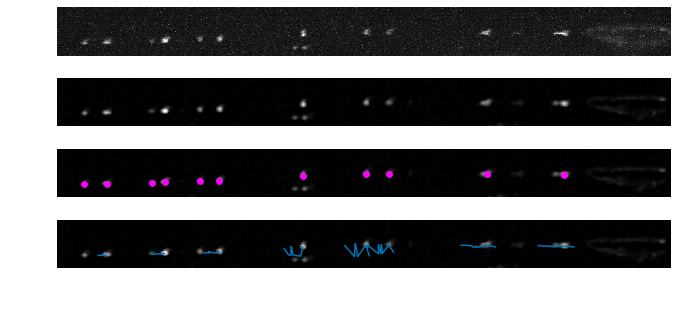

In [14]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(11,5), #tight_layout=True,
                        subplot_kw={'aspect': 'equal'})
magenta_cmap = mpl.colors.LinearSegmentedColormap.from_list('my_magenta', ['white', '#FF00FF'], N=256)
magenta_patch = mpl.patches.Patch(color='#FF00FF', label='0 kPa')

axes[0].imshow(maxProjection.T, **plot_kwargs,
               vmin=maxProjection[top:bottom].min(),
               vmax=maxProjection[top:bottom].max())
axes[0].set_ylim(bottom, top)
axes[0].axis('off')

axes[1].imshow(max_proj_bp.T, **plot_kwargs,
              vmin=max_proj_bp.T[top:bottom].min(),
              vmax=max_proj_bp.T[top:bottom].max())
axes[1].set_ylim(bottom, top)
axes[1].axis('off')

axes[2].imshow(max_proj_bp.T, **plot_kwargs,
              vmin=max_proj_bp.T[top:bottom].min(),
              vmax=max_proj_bp.T[top:bottom].max())
sns.scatterplot(x='y', y='x', ax=axes[2], color='magenta', edgecolor=None,
               data=unlinked_mitos_df.loc[unlinked_mitos_df['frame']==0])
axes[2].set_ylim(bottom, top)
axes[2].axis('off')

axes[3].imshow(max_proj_bp.T,  **plot_kwargs, 
               vmin=max_proj_bp.T[top:bottom].min(),
               vmax=max_proj_bp.T[top:bottom].max())
for this_particle in linked_mitos_df['particle'].unique():
    sns.lineplot(x='y', y='x', ax=axes[3], color=sns.color_palette('colorblind')[0],
                 data=linked_mitos_df.loc[linked_mitos_df['particle'] == this_particle])
axes[3].set_ylim(bottom, top)
axes[3].axis('off');

# fig.patch.set_facecolor('black')
fig.savefig(fig_save_dir.joinpath('image_analysis_pipeline.pdf'),# bbox_inches='tight', pad_inches=0,
     facecolor='w')

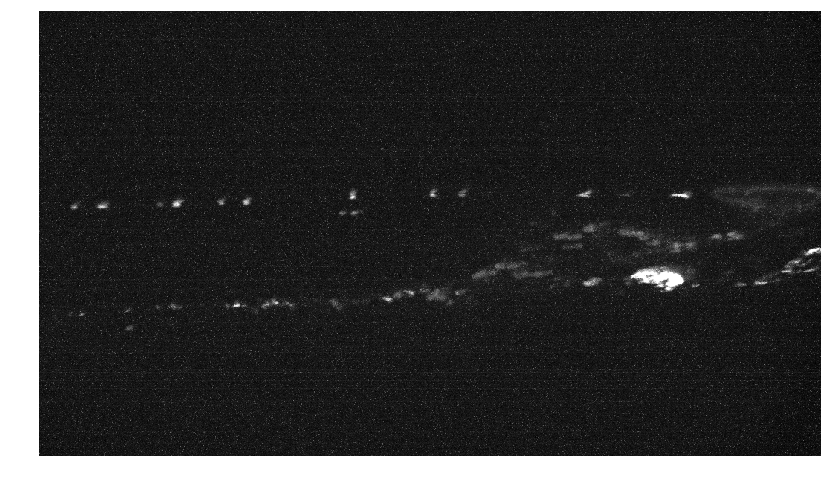

In [15]:
fig, ax = plt.subplots(figsize=(14, 10))

ax.imshow(maxProjection.T,
         cmap='Greys_r', aspect='equal',
         vmin=maxProjection[top:bottom].min(),
         vmax=maxProjection[top:bottom].max())
ax.axis('off');

fig.savefig(fig_save_dir.joinpath('example_image.pdf'), bbox_inches='tight', pad_inches=0,)

In [16]:
print('Notebook took', str(int(time.time()-start)), 'seconds to run.')

Notebook took 43 seconds to run.
